<a href="https://colab.research.google.com/github/MehakArora/ImageInpainting/blob/main/New_Vanilla_Encodeer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install --upgrade opencv-contrib-python
!pip install tensorflow-gpu==2.0

In [25]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.python.client import device_lib

print('[INFO]', tf.config.experimental.list_physical_devices('GPU')[0])

2.0.0
[INFO] PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [26]:
import os
import cv2
print(cv2.__version__)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from skimage.metrics import structural_similarity as SSIM

from mpl_toolkits.axes_grid1 import ImageGrid

4.5.5


In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "/content/drive/MyDrive/ECE_6254/archive(1).zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

In [29]:
"Getting File Names"

#Train Data
train_path = './seg_train/seg_train/'
train_folders = os.listdir(train_path)
train_files = []

for folder in train_folders:
    files_f = os.listdir(train_path + folder + '/')
    for file in files_f:
        train_files.append(train_path + folder + '/' + file)
        
#Val Data
val_path = './seg_test/seg_test/'
val_folders = os.listdir(val_path)
val_files = []

for folder in val_folders:
    files_f = os.listdir(val_path + folder + '/')
    for file in files_f:
        val_files.append(val_path + folder + '/' + file)
  
#Testing Data
pred_path = './seg_pred/seg_pred/'
pred_files = []


for file in os.listdir(pred_path):
    pred_files.append(pred_path + file)

In [30]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(64, 64), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      X_inputs, y_output = self.__data_generation(indexes)
      return X_inputs, y_output

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # Masked_images is a matrix of masked images used as input
    Masked_images = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # Mask_batch is a matrix of binary masks used as input
    Mask_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Binary Masks
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image
    

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
      ## Get mask associated to that image
      masked_image, mask = self.__createMask(image_copy)
      
      Masked_images[i,] = masked_image/255
      Mask_batch[i,] = mask/255
      y_batch[i] = self.y[idx]/255

    ## Return mask as well because partial convolution require the same.
    return [Masked_images, Mask_batch], y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((64,64,3), 255, np.uint8) ## White background
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 64), np.random.randint(1, 64)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 64), np.random.randint(1, 64)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 3)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(0,0,0),thickness)

    ### Mask the image
    #masked_image = img.copy()
    #masked_image[mask==0] = 255

    # Perforn bitwise and operation to mak the image
    try:
      masked_image = cv2.bitwise_and(img, mask)

    except:
      print("Img.shape: ", img.shape)
      print("Mask.shape: ",mask.shape)

    return masked_image, mask

In [31]:
import cv2

x_train = []
for file_path in train_files:
  img = cv2.imread(file_path)
  resized = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  x_train.append(resized)
  
x_train = np.array(x_train)


x_val = []
for file_path in val_files:
  img = cv2.imread(file_path)
  resized = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  x_val.append(resized)
  
x_val = np.array(x_val)

x_pred = []
for file_path in pred_files:
  img = cv2.imread(file_path)
  resized = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  x_pred.append(resized)
  
x_pred = np.array(x_pred)


(64, 64, 3)


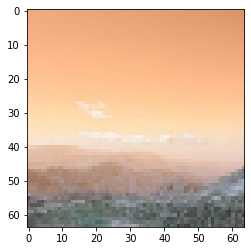

In [32]:
img = x_train[0]
print(img.shape)
plt.imshow(img)


In [33]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_val, x_val, shuffle=False)

In [34]:
def dice_coef(y_true, y_pred):
   y_true_f = keras.backend.flatten(y_true)
   y_pred_f = keras.backend.flatten(y_pred)
   intersection = keras.backend.sum(y_true_f * y_pred_f)
   return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [35]:
class inpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(64,64,3)):
    inputs = keras.layers.Input(input_size)

    conv1, pool1 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 
    
    conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    
    conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)
    
    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

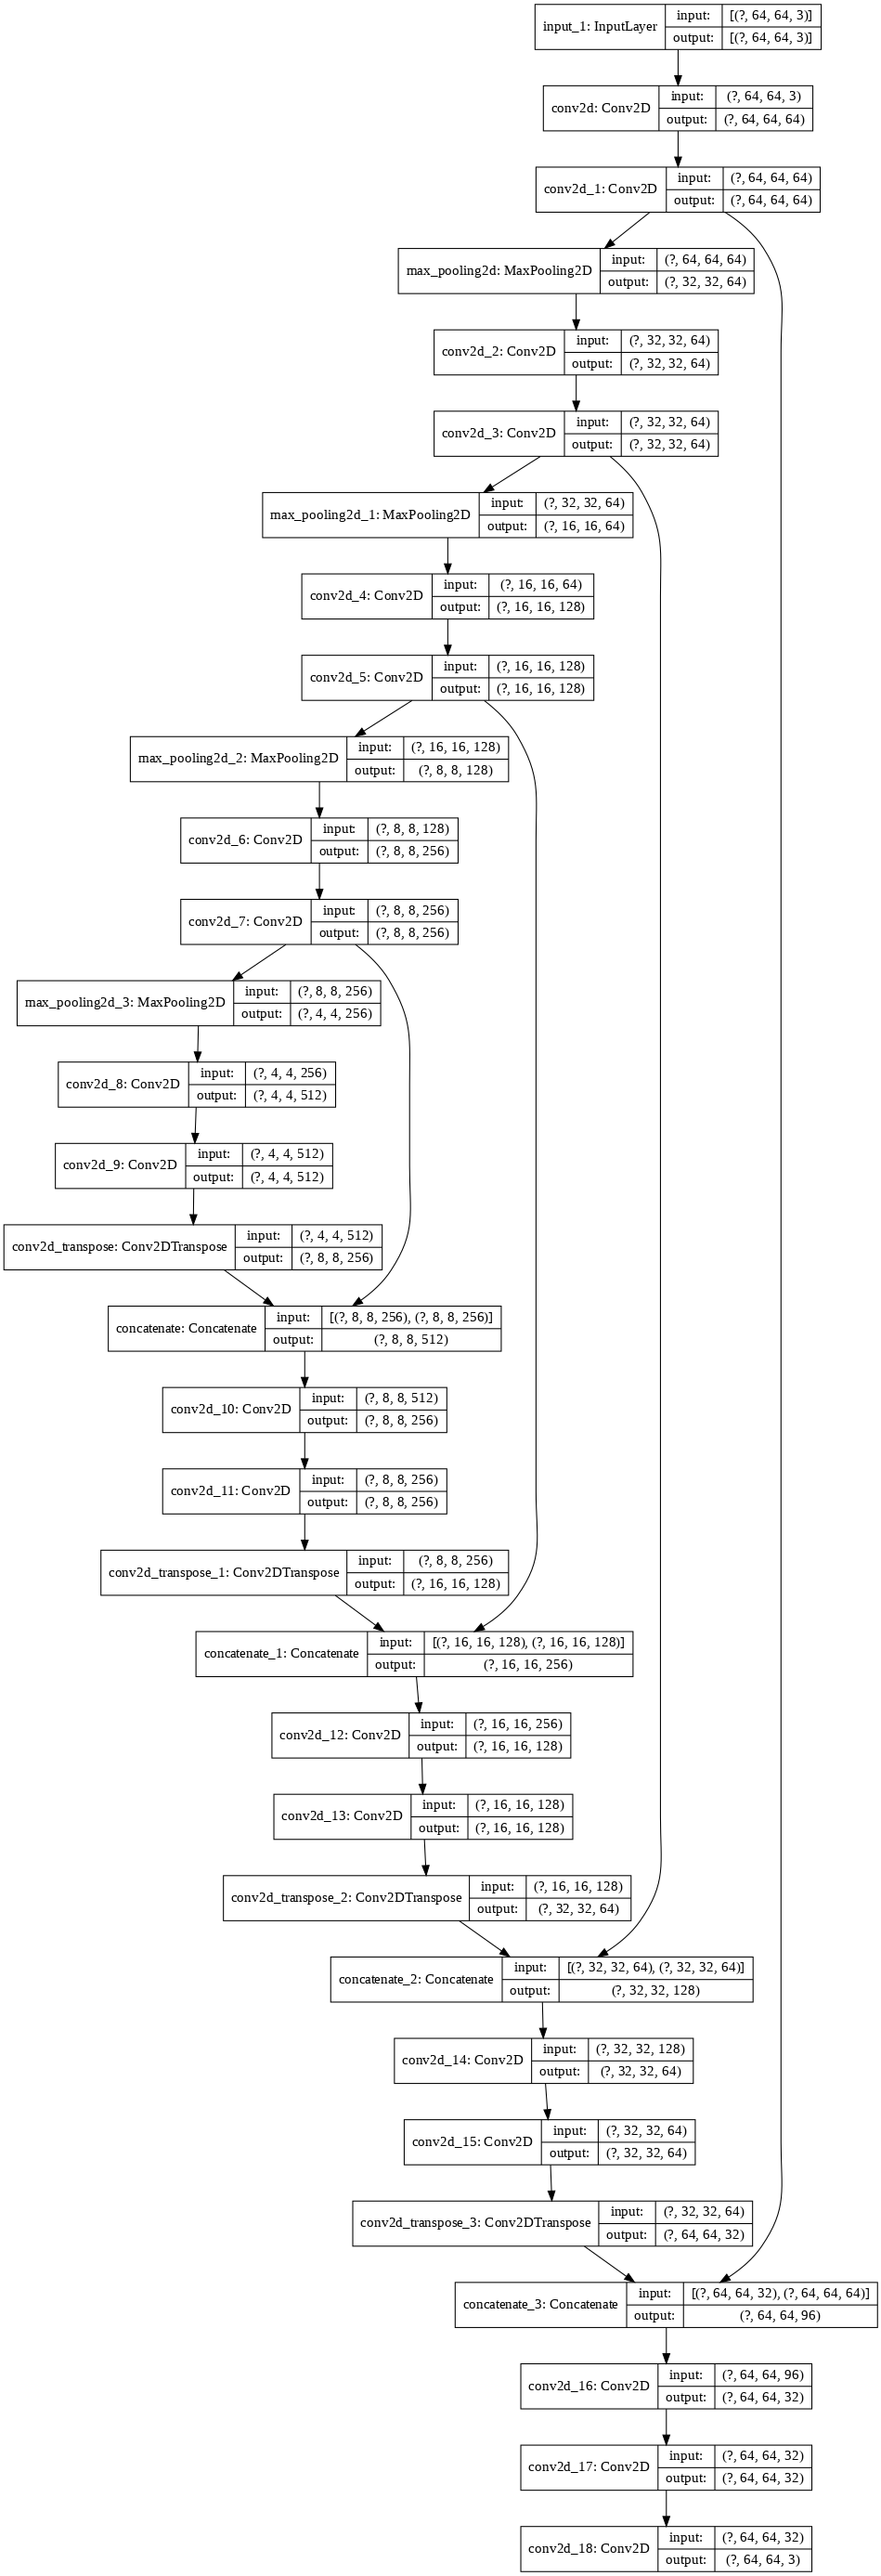

In [36]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v1.png')

In [37]:
class PredictionLogger(tf.keras.callbacks.Callback):
   def __init__(self):
       super(PredictionLogger, self).__init__()

       # The callback will be executed after an epoch is completed
   def on_epoch_end(self, logs, epoch):
       # Pick a batch, and sample the masked images, masks, and the labels
       sample_idx = 54
       sample_images, sample_labels = testgen[sample_idx] 
       
       # Initialize empty lists store intermediate results
       m_images = []
       predictions = []
       labels = []
       
       # Iterate over the batch
       for i in range(32):
         # Our inpainting model accepts masked imaged and masks as its inputs,
         # then use perform inference
         impainted_image = self.model.predict(np.expand_dims(sample_images[i], axis=0))
       
         # Append the results to the respective lists
         m_images.append(sample_images[i])
         labels.append(sample_labels[i])
         predictions.append(impainted_image.reshape(impainted_image.shape[1:]))

In [39]:
_ = model.fit_generator(traingen, 
          validation_data=testgen, 
          epochs=20, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True)
          #callbacks=[PredictionLogger()])

Epoch 1/20
438/438 [==============================] - 93s 212ms/step - loss: 0.0471 - dice_coef: 0.5861 - val_loss: 0.0208 - val_dice_coef: 0.5883
Epoch 2/20
438/438 [==============================] - 88s 201ms/step - loss: 0.0216 - dice_coef: 0.5964 - val_loss: 0.0164 - val_dice_coef: 0.5902
Epoch 3/20
438/438 [==============================] - 87s 200ms/step - loss: 0.0178 - dice_coef: 0.5974 - val_loss: 0.0163 - val_dice_coef: 0.5861
Epoch 4/20
438/438 [==============================] - 87s 199ms/step - loss: 0.0169 - dice_coef: 0.5977 - val_loss: 0.0237 - val_dice_coef: 0.5962
Epoch 5/20
438/438 [==============================] - 87s 200ms/step - loss: 0.0152 - dice_coef: 0.5979 - val_loss: 0.0143 - val_dice_coef: 0.5868
Epoch 6/20
438/438 [==============================] - 87s 199ms/step - loss: 0.0150 - dice_coef: 0.5981 - val_loss: 0.0123 - val_dice_coef: 0.5893
Epoch 7/20
438/438 [==============================] - 87s 198ms/step - loss: 0.0138 - dice_coef: 0.5984 - val_loss: 0.

In [ ]:
def dice_coef(y_true, y_pred):
   y_true_f = keras.backend.flatten(y_true)
   y_pred_f = keras.backend.flatten(y_pred)
   intersection = keras.backend.sum(y_true_f * y_pred_f)
   return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

def get_psnr(y_true, y_pred):
  val = tf.image.psnr(y_true, y_pred, 1)
  return val

def get_ssim(y_true, y_pred):
  y_true_tensor = tf.image.convert_image_dtype(y_true, tf.float32)
  y_pred_tensor = tf.image.convert_image_dtype(y_pred, tf.float32)
  val = tf.image.ssim(y_true_tensor, y_pred_tensor, 1)
  return float(val)

def get_dice_coef(y_true, y_pred):
  y_true_double = tf.image.convert_image_dtype(y_true, tf.double)
  y_pred_double = tf.image.convert_image_dtype(y_pred, tf.double)
  return dice_coef(y_true_double, y_pred_double)

Image (1): PSNR = 34.617493, SSIM = 0.986594
Image (2): PSNR = 36.552643, SSIM = 0.978103
Image (3): PSNR = 32.780029, SSIM = 0.937861
Image (4): PSNR = 45.444500, SSIM = 0.995560
Image (5): PSNR = 28.032598, SSIM = 0.918324
Image (6): PSNR = 42.854454, SSIM = 0.991626
Image (7): PSNR = 37.743862, SSIM = 0.980478
Image (8): PSNR = 40.533516, SSIM = 0.997355
Image (9): PSNR = 32.177525, SSIM = 0.954356
Image (10): PSNR = 28.218594, SSIM = 0.961743
Image (11): PSNR = 25.596184, SSIM = 0.948792
Image (12): PSNR = 34.446095, SSIM = 0.992287
Image (13): PSNR = 25.650089, SSIM = 0.906441
Image (14): PSNR = 30.678499, SSIM = 0.979569
Image (15): PSNR = 34.959438, SSIM = 0.986614
Image (16): PSNR = 32.583740, SSIM = 0.967824
Image (17): PSNR = 30.091284, SSIM = 0.896148
Image (18): PSNR = 38.774235, SSIM = 0.993704
Image (19): PSNR = 28.398905, SSIM = 0.972094
Image (20): PSNR = 32.611443, SSIM = 0.964632
Image (21): PSNR = 32.051445, SSIM = 0.970232
Image (22): PSNR = 29.952564, SSIM = 0.9427

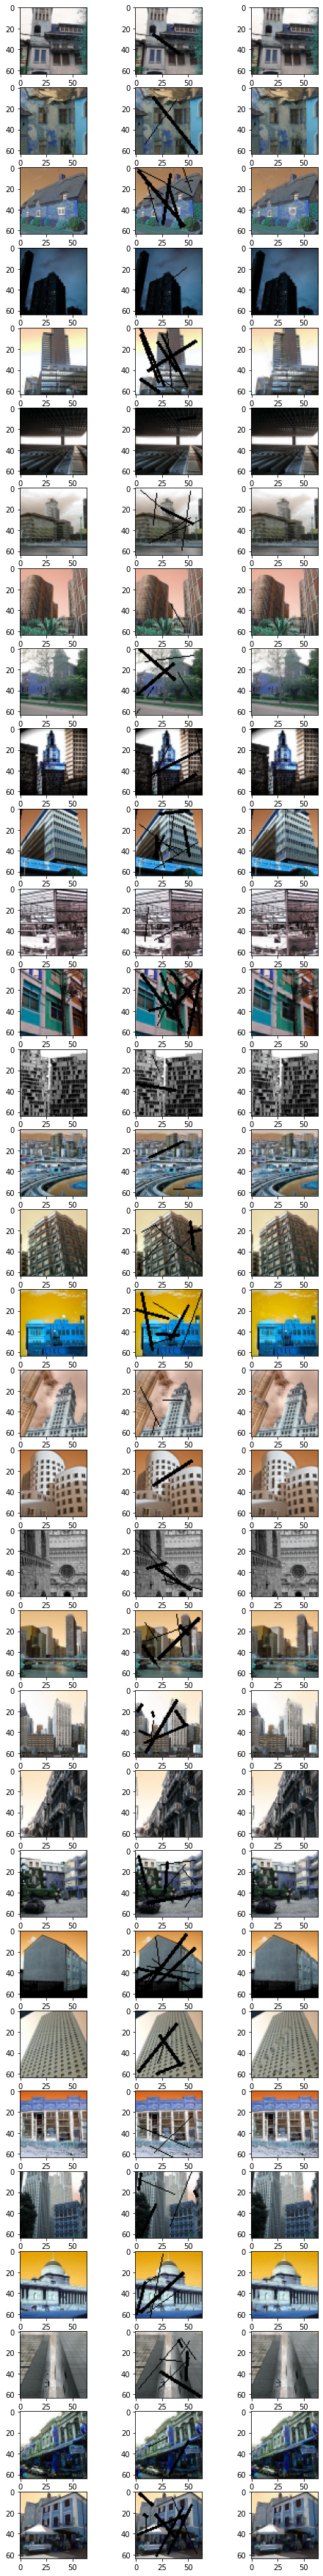

In [43]:
rows = 32
sample_idx = 70
[masked_images, masks], sample_labels = testgen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(8, 2*rows))

for i in range(32):
  inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
  impainted_image = model.predict(inputs)

  ## Metrics old
  #img_orig_gray = cv2.cvtColor(sample_labels[i].astype('uint8'),cv2.COLOR_BGR2GRAY)
  #img_inpainted_gray = cv2.cvtColor(impainted_image.reshape(impainted_image.shape[1:]).astype('uint8'),cv2.COLOR_BGR2GRAY)
  #PSNR_val = cv2.PSNR(img_orig_gray, img_inpainted_gray, 255)
  ##print(PSNR)
  ##SSIM_val = SSIM(sample_labels[i], impainted_image.reshape(impainted_image.shape[1:]),multichannel=True)
  #SSIM_val = SSIM(img_orig_gray, img_inpainted_gray,multichannel=True)

  # Metrics new
  PSNR_val = get_psnr(sample_labels[i],impainted_image.reshape(impainted_image.shape[1:]).astype('float64'))
  SSIM_val = get_ssim(sample_labels[i],impainted_image.reshape(impainted_image.shape[1:]))
  print("Image (%i): PSNR = %f, SSIM = %f"%(i+1,PSNR_val,SSIM_val))

  # Plotting:
  axs[i][0].imshow(sample_labels[i])                                              # Ground truth
  axs[i][1].imshow(masked_images[i])                                              # Masked image
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))            # Inpainted image
  #axs[i][0].set_xlabel('PSNR : ' + str(PSNR_val) + '\nSSIM: ' + str(SSIM_val))
  
  #axs[i][0].imshow(masked_images[i])
  #axs[i][1].imshow(masks[i])
  #axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  ##print(impainted_image.shape[1:])
  #axs[i][3].imshow(sample_labels[i])
  ##print(sample_labels[i])
  
plt.show()
fig.savefig("test2.png",dpi=600)

In [41]:
model.save("./drive/MyDrive/ECE_6254/my_new_model")

INFO:tensorflow:Assets written to: ./drive/MyDrive/ECE_6254/my_new_model/assets


In [42]:
## METRICS

metrics = {"PSNR":[],
          "SSIM":[],
          "Dice": []}

for idx in range(len(testgen)):
  [masked_images, masks], sample_labels = testgen[idx]
  for i in range(32):
    inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
    impainted_image = model.predict(inputs)
    # Metrics new
    PSNR_val = get_psnr(sample_labels[i],impainted_image.reshape(impainted_image.shape[1:]).astype('float64'))
    SSIM_val = get_ssim(sample_labels[i],impainted_image.reshape(impainted_image.shape[1:]))
    Dice_coeff = get_dice_coef(sample_labels[i],impainted_image.reshape(impainted_image.shape[1:]))

    metrics["PSNR"].append(PSNR_val)
    metrics["SSIM"].append(SSIM_val)
    metrics["Dice"].append(Dice_coeff)

print("Average PSNR: %f\nAverage SSIM: %f\nAverage Dice coeff: %f" %(np.average(metrics["PSNR"]),np.average(metrics["SSIM"]),np.average(metrics["Dice"])))
#print("Average PSNR: %f\nAverage SSIM: %f" %(np.average(metrics["PSNR"]),np.average(metrics["SSIM"])))

Average PSNR: 34.514198
Average SSIM: 0.966412
Average Dice coeff: 0.575846
